## da_rnn_from_csv  
#### (only tested on 3.5 and up)
___
This version of da_rnn is derived from Chandler Zuo's implementation of the paper:  
[*A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction*](https://arxiv.org/pdf/1704.02971.pdf)  
which he details in his blog post  
[*A PyTorch Example to Use RNN for Financial Prediction*](http://chandlerzuo.github.io/blog/2017/11/darnn)

My implementation does the following:
* You can replace the input data with other times series csvs.  
  Change the input csv file by changing the first 2 lines of the code block in **section 4.01**. 

  ```
        if __name__=='__main__':
           fname_no_ext = 'nasdaq100_padding'
           rows_to_use = 5000
           ...
  ```

* You can easily save the ipynb notebook as a python py file, that can be imported
   into other ipynb notebooks or other python projects.  
   Use the bash command:  
     ```jupyter nbconvert da_rnn_from_csv.ipynb --to python ```


* You can pickle the da_rnn class:  
  ``` pickle.dump(m,open(f'{fname_no_ext}.pt','wb')) ```  
  Then reload it and use it to make more predictions:  
  ``` m_from_pickle = pickle.load(open(f'{fname_no_ext}.pt','wb')) ```
 
  


___
## Use:  
___
To use this ipynb notebook, run all of the notebook's cells.  
In **section 4.0**, you can change the data from <span style="color:blue">nasdaq100</span> component data to <span style="color:blue">uso</span> 1-minute time bars.

The cell with the ```if __name__=='__main___``` code (in **section 4.0**) will launch:  
* Instantiating the model,
* Training of the model,
* Saving of the model,
* Reloading the model,
* Rerunning predictions using the saved model


___
## Data:
The folder **data** contains several csv files:
* <span style="color:blue">nasdaq100_padding.csv</span> - original csv file used by Chandler Zuo of NDX components
* <span style="color:blue">uso_full.csv</span> - one minute bar data for the commodity ETF USO
* <span style="color:blue">uso_201812.csv</span> - one minute bar data just for December 2018

You can train the model using any of these csv files, or any other csv whose columns conform to those examples.  You can also use another time series csv file with numeric columns.  One of those numeric columns should be used as the label/y-value for the x-values of the preceeding row.


___
## Structure of the csv/DataFrame:
The data in the csv/DataFrame can contain rows like:  
1. the returns data for the components of an index like NDX (as in Chandler Zuo's version) as in the csv file ./data/nasdaq100_padding.csv, or 
2. intra-day bar data with columns like **year, month, day, hour, minute open, high, low, close**, as in the csv file ./data/uso_full.csv

___
## The main() method in section 3.0
The actual model training takes place in the **main()** method in the cell below heading **3.01**, with the code:

```
    logger = setup_log()
    m = da_rnn(df_partial, logger = logger, parallel = False, learning_rate = .001)
    m.execute_training(n_epochs=100)
```

  

___
## Using pdb 
To use the pdb debuger, add pdb.set_trace() statements to the code.  
[See this cheatsheet for a quick reference to pdb commands](https://appletree.or.kr/quick_reference_cards/Python/Python%20Debugger%20Cheatsheet.pdf)
  

### 1.0 Define dependencies

In [1]:
import pdb
import  numpy as np
import torch 
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import logging
import subprocess
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pickle
# from sklearn.manifold import TSNE

# local_data_dir = './temp_folder'
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


#### 1.01 Define a method that creates a python logger 

In [2]:
def setup_log(tag = 'VOC_TOPICS'):
    # create logger
    logger = logging.getLogger(tag)
    # logger.handlers = []
    logger.propagate = False
    logger.setLevel(logging.DEBUG)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    # logger.handlers = []
    logger.addHandler(ch)
    return logger



### 2.0 Define the main components of the RNN model
#### 2.01 Define the encoder:

___
#### Encoder equations:
(_in the equations below, m = hidden size_)

* (equation 8) &nbsp;   &nbsp;   &nbsp;   &nbsp;   &nbsp;  $e_t^k = \mathbf{v_e}^\top  tanh(\mathbf{W_e}[\mathbf{h}_{t−1}; \mathbf{s}_{t−1}] + \mathbf{U_ex^k})$  
 * where $\mathbf{v_e}∈R^T, \mathbf{W_e}∈R^{T×2m} \  and \  \mathbf{U_e}∈R^{T×T}$
 * $\mathbf{v_e}^\top$ is calculated using a <span style="color:red">tensor(batch_size * input_size,T)</span> that is learned using <span style="color:blue">nn.Linear(in_features = T-1, out_features = 1)</span>
 * $\mathbf{W_e}[\mathbf{h}_{t−1}; \mathbf{s}_{t−1}]$ is calculated using a <span style="color:red">tensor(batch_size * input_size,2*m)</span> that is learned using <span style="color:blue">nn.Linear(in_features = 2m, out_features = T-1)</span>

* (equation 9)  &nbsp;   &nbsp;   &nbsp; $α_t^k = \frac{exp(e_t^k)}{\sum\limits_{i=1} exp(e_t^i)} $ &nbsp;   &nbsp;   &nbsp;  (this is the softmax)  

* (equation 10)  &nbsp;   &nbsp;   &nbsp;  $\tilde{x_t} = (α_t^1 e_t^1,α_t^2 e_t^2,...,α_t^n e_t^n)^\top$ &nbsp;   &nbsp; where n = number of features

* (equation 11) &nbsp;   &nbsp;   &nbsp;  $\mathbf{h}_t = f_1(\mathbf{h}_{t−1},\mathbf{x}_t)$ &nbsp;   &nbsp; (this is the LSTM execution)


In [3]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.v_e = nn.Linear(in_features = self.T-1,out_features = 1)
        self.W_ehs = nn.Linear(in_features = self.hidden_size*2,out_features = T-1)
        self.U_e =  nn.Linear(in_features = self.T-1,out_features = self.T-1)
        self.lstm_layer_x_hat = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)

    def forward(self, input_data):
        # T is the number of time steps that we iterate through to implement attention
        # input_size is the number of features in the input data
        # input_data.shape:     batch_size, T - 1, input_size
        # input_weighted.shape: batch_size, T - 1, input_size
        # input_encoded.shape:  batch_size, T - 1, hidden_size
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
#         pdb.set_trace()
        
        # hidden, cell: initial states with dimention hidden_size
        # hidden.shape = 1, batch_size, hidden_size
        hidden = self.init_hidden(input_data)
        # cell.shape = 1, batch_size, hidden_size
        cell = self.init_hidden(input_data) 
        # hidden.requires_grad = False
        # cell.requires_grad = False
        
        # In each loop of t, we execute Equations 8, 9, and 10
        #   we execute the equation 8.  Equation 8 produces, as the author wrote it, produces scalar values
        #   that represent 
        # input_encoded contains the h values that get fed into the decoder
        # input_weighted contains the x values that get fed into into the encoder's lstm on each time-step.
        for t in range(self.T - 1):
            
            # ************************************* Equation 8 *******************************************
            # Execute equation 8
            c1 = hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2)   # torch tensor dimensions = [batch_size, input_size, hidden_size]
            c2 = cell.repeat(self.input_size, 1, 1).permute(1, 0, 2)     # torch tensor dimensions = [batch_size, input_size, hidden_size]
#             c3 = input_data.permute(0, 2, 1)                             # torch tensor dimensions = [batch_size, input_size, T-1]

            #  Create input data for W_e dot hidden(t-1) concatentated with cell(t-1)
            h_cat_s = torch.cat((c1,c2),dim=2).reshape(-1,self.hidden_size*2) # batch_size * input_size, 2*hidden_size

            # Execute W_e dot [hidden(t-1) concatentated with cell(t-1)].  However,
            #    execute that Linear transformation for all batch elements
            W_e_dot_h_cat_s = self.W_ehs(h_cat_s) # batch_size * input_size, T-1

            # Execute U_e dot x_k in equation 8.  In this case,
            #    U_e is a T X T Linear transformation, and x_k is a vector of one feature, but for all time
            #      steps T-1.  
            #    When we execute this Linear transformation using self.U_e, you feed self.U_e a Matrix where
            #      the rows are x_k for all feature in all batches
            x_k = input_data.permute(0,2,1).reshape(-1,self.T-1)
            U_e_dot_x_k = self.U_e(x_k) # batch_size * input_size, T-1

            # Sum the output of W_e and U_e transformations.
            #    Both of these transformations produce T-1 columns
            W_e_U_e_sum = W_e_dot_h_cat_s + U_e_dot_x_k # batch_size * input_size, T-1

            # Execute tanh ot the sum in order to normalized the values from -1 to 1
            tanh = F.tanh(W_e_U_e_sum) # batch_size * input_size, T-1

            # Execute v_e dot tanh which produces single values for each feature k, for each time t.
            #    self.v_e executes this transformation on all features, for all batch elements
            v_e = self.v_e(tanh) # batch_size * input_size, 1

            # Reshape the data back into columns of features
            #   get rows where each row has all k0, k1, ... n features
            v_e_k = v_e.reshape(-1,self.input_size) # batch_size, input_size
            # *********************************************************************************************

            # ************************************* Equation 9 ******************************************
            # Run Equation 9 - softmax on the features to get probabilities 
            a_e_k = F.softmax(v_e_k) # batch_size, input_size
            # *********************************************************************************************

            # ************************************** Equation 10 *********************************************
            # *Run Equation 10 - Multiply the softmax weights with the actual x values
            x_hat = torch.mul(a_e_k,input_data[:,t,:]) # batch_size, input_size
            # *********************************************************************************************

            # ************************************** Equation 11 *******************************************
            # Run Equation 11 - Input the weighted x values in x_hat to the LSTM to get new hidden and cell states
            _, lstm_x_hat_states = self.lstm_layer_x_hat(x_hat.unsqueeze(0),(hidden,cell))
            # *********************************************************************************************

            # Update the hidden and cell state for the next loop of t
            hidden = lstm_x_hat_states[0]
            cell = lstm_x_hat_states[1]
            # Save output
            input_weighted[:, t, :] = x_hat
            input_encoded[:, t, :] = hidden

        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension
        


#### 2.02 Define the decoder:

___
#### Decoder equations:
(_in the equations below, m = hidden size, p=decoder hidden size_)

* (equation 12) &nbsp;   &nbsp;   &nbsp;   &nbsp;   &nbsp;  $l_t^i = \mathbf{v_d}^\top  tanh(\mathbf{W_d}[\mathbf{d}_{t−1}; \mathbf{s^\prime}_{t−1}] + \mathbf{U_dh_i})$  
 * where $\mathbf{v_d}∈R^m, \mathbf{W_d}∈R^{m×2p} \  and \  \mathbf{U_d}∈R^{m×m}$
 * $\mathbf{v_d}^\top$ is calculated using a <span style="color:red">tensor(batch_size * (T-1),m)</span> that is learned using <span style="color:blue">nn.Linear(in_features = m, out_features = 1)</span>
 * $\mathbf{W_d}[\mathbf{d}_{t−1}; \mathbf{s^\prime}_{t−1}]$ is calculated using a <span style="color:red">tensor(batch_size * (T-1),2*m)</span> that is learned using <span style="color:blue">nn.Linear(in_features = 2m, out_features = m)</span>

* (equation 13)  &nbsp;   &nbsp;   &nbsp; $\beta_t^i = \frac{exp(l_t^i)}{\sum\limits_{j=1}^{T} exp(l_t^i)} $ &nbsp;   &nbsp;   &nbsp;  (*this is the softmax*)  

* (equation 14)  &nbsp;   &nbsp;   &nbsp;  ${\mathbf{c}_t} = {\sum\limits_{i=1}^{T} \beta_t^i \mathbf{h}_i}$ &nbsp;   &nbsp; (*where i is each encoder_hidden time step*)

* (equation 15) &nbsp;   &nbsp;   &nbsp;  $\tilde{y}_{t−1} = \tilde{\mathbf{w}}^\top [y_{t−1};\mathbf{c}_{t−1}] + \tilde{b} $ &nbsp;   &nbsp;  (*calculate y_hat using context vector and previous y value*)

* (equation 16) &nbsp;   &nbsp;   &nbsp;  $\mathbf{d} = f_2(\mathbf{d}_{t-1},\tilde{y}_{t-1})$ &nbsp;   &nbsp;    (*this is the LSTM*)


In [4]:
class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        
        # ************* Eq 12 **********************
        self.v_d = nn.Linear(in_features = self.encoder_hidden_size,out_features = 1) 
        self.W_dhs = nn.Linear(in_features = 2 * self.decoder_hidden_size,out_features = encoder_hidden_size) 
        self.U_d =  nn.Linear(in_features = self.encoder_hidden_size,out_features = self.encoder_hidden_size)
        # ************* Eq 12 **********************
        
        # ************** Eq 13 and 14 done in forward method *************
        
        # ************* Eq 15 **********************
        self.w = nn.Linear(in_features = 1+self.encoder_hidden_size,out_features = 1)
        self.w.weight.data.normal_()

        # ************* Eq 15 **********************


#         self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
#                                          nn.Tanh(), nn.Linear(encoder_hidden_size, 1))

        # ************* Eq 16 **********************
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        # ************* Eq 16 **********************
        
#         self.fc = nn.Linear(encoder_hidden_size + 1, 1)
#         self.fc.weight.data.normal_()

        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)


    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size,T - 1,encoder_hidden_size
        # y_history: batch_size, (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)


        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            
            
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            c1 = hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2) # batch_size,T-1,hidden_size
            c2 = cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2) # batch_size,T-1,hidden_size

            # ************* Eq 12 **********************
            x = torch.cat((c1,c2), dim = 2).reshape(-1,2*self.decoder_hidden_size)
            W_dhs_dot_ds = self.W_dhs(x)
            h_i = input_encoded.reshape(-1,self.encoder_hidden_size)
            U_d_dot_h_i = self.U_d(h_i)
            tanh = F.tanh(W_dhs_dot_ds + U_d_dot_h_i)
            l_i_t = self.v_d(tanh)
            lit_t = l_i_t.reshape(-1,self.T-1)
            # ************* Eq 12 **********************

            # ************* Eq 13 **********************
            b_i_t = F.softmax(lit_t)
            bit_t = b_i_t.reshape(-1,self.T-1)
            # ************* Eq 13 **********************
            
            # ************* Eq 14 **********************
            bit_t_3d = bit_t.unsqueeze(1)
            context = torch.bmm(bit_t_3d,input_encoded).reshape(-1,self.encoder_hidden_size)
            # ************* Eq 14 **********************
#           
#             c3 = input_encoded # batch_size,T-1,hidden_size
#             x = torch.cat((c1,c2, c3), dim = 2)
#             x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
#                                                 )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1

#             # Eqn. 14: compute context vector
#             context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size

            if t < self.T - 1:
                # ********************** Eqn. 15 ***********************
#                 y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size, 1
                y_tilde = self.w(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size, 1
                # ********************** Eqn. 15 ***********************

                # ********************** Eqn. 16: LSTM **********************
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                # ********************** Eqn. 16: LSTM **********************

                # update values
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())


#### 2.03 Define the RNN class, that uses the encoder and decoder

In [5]:
class da_rnn:
    # the __getstate__ and __setstate__ methods allow you to avoid trying to pickle the logger.
    def __getstate__(self):
        d = dict(self.__dict__)
        del d['logger']
        return d
    
    def __setstate__(self, d):
        self.__dict__.update(d) 
        self.logger = setup_log()
    
    
    def __init__(self, df_dat, logger, encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = False,ticker='NDX'):
        self.df_dat = df_dat
        self.T = T
        self.logger = logger
        self.logger.info("Shape of data: %s.\nMissing in data: %s." %(str(df_dat.shape), str(df_dat.isnull().sum().sum())))
        self.x_columns = [x for x in df_dat.columns.tolist() if x != ticker]
        self.X = df_dat.loc[:, self.x_columns].as_matrix()
        self.y = np.array(df_dat[ticker])
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T)
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T)
        
        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        self.ticker = ticker
        self.train_size = int(self.X.shape[0] * 0.7)
        self.y_train_mean = np.mean(self.y[:self.train_size])
        self.y = self.y - self.y_train_mean # Question: why Adam requires data to be normalized?
        self.logger.info("Training size: %d."  %(self.train_size))

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        self.logger.info("Iterations per epoch: %d." %(iter_per_epoch))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in range(n_epochs):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                
                batch_idx = perm_idx[j:min(j + self.batch_size,len(perm_idx))]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                self.iter_losses[int(i * iter_per_epoch + j / self.batch_size)] = loss
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                if learning_rate > self.learning_rate:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    learning_rate *= .9
                '''


            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 10 == 0:
                self.logger.info("Epoch %d, loss: %3.3f." %(i, self.epoch_losses[i]))

            if i % 10 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        
        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor)))
        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor)).reshape(y_target.shape[0],1)
        
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.data[0]

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]
            
            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor))
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            
            i += self.batch_size
        return y_pred

    def execute_training(self,n_epochs=500):
        use_cuda = torch.cuda.is_available()
        self.logger.info("Is CUDA available? %s." %(str(use_cuda)))


        self.train(n_epochs = n_epochs)

        y_pred = self.predict()

        plt.figure()
        plt.semilogy(range(len(self.iter_losses)), self.iter_losses)
        plt.show()

        plt.figure()
        plt.semilogy(range(len(self.epoch_losses)), self.epoch_losses)
        plt.show()

        plt.figure()
        plt.plot(y_pred, label = 'Predicted')
        plt.plot(self.y[self.train_size:], label = "True")
        plt.legend(loc = 'upper left')
        plt.show()


#### 2.04 Define pred_df to execute predictions from a DataFrame

In [6]:
def pred_df(df_test,model):
    # get the x values for the prediction
    x_values = df_test[model.x_columns].as_matrix()
    m_y = df_test[model.ticker].as_matrix() - model.y_train_mean
    m_t = model.T
    m_batch_size = model.batch_size
    y_pred = np.zeros(x_values.shape[0] - m_t)
    on_train=False
    rlp = range(len(y_pred))
    b_idx = np.array(rlp)

    i=0
    while i < len(y_pred):
        batch_idx = b_idx[i : (i + m_batch_size)]
        # calculate batch size, b/c on the last batch, it will be less that model.batch_size
        batch_length = len(batch_idx)
        X = np.zeros((batch_length, m_t - 1, x_values.shape[1]))
        y_history = np.zeros((batch_length, m_t - 1))
        for j in range(batch_length):
            test_index_start = batch_idx[j] 
            test_index_end = min(batch_idx[j],m_y.shape[0]) +  m_t - 1 
            X[j, :, :] = x_values[range(test_index_start, test_index_end), :]
            y_history[j, :] = m_y[range(test_index_start,  test_index_end)]

        y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor))
        _, input_encoded = model.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
        y_pred[i:(i + m_batch_size)] = model.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
#         pdb.set_trace()

        i += m_batch_size
    
    
    
    return y_pred


## 3.0 Define main method that launches the training of the RNN

#### 3.01 The main() method:
  1. Read's the main csv file into a pandas DataFrame,
  2. Selects a subset of that DataFrame's rows,
  3. Instantiates a logger,
  4. Instanstiates an instance of da_rnn,
  5. Calls execute_training,
  6. Run predictions using the pred_df method and model.predict .
  

In [7]:
def main(FILE_NAME_NO_EXTENSION=None,subset_rows=10000):
    
    DATA_DIR = './data'
    FILE_NAME_NO_EXT = FILE_NAME_NO_EXTENSION
    if FILE_NAME_NO_EXT is None:
        FILE_NAME_NO_EXT = 'nasdaq100_padding'
        # FILE_NAME_NO_EXT = 'uso_full'
    data_file = f'{DATA_DIR}/{FILE_NAME_NO_EXT}.csv'

    # get data
    df = pd.read_csv(data_file)
    print(df.columns.values,df.as_matrix().shape)

    # set label_column and also use the close as the labels if you have open,high,low,close data
    label_column = 'NDX'
    if 'close' in df.columns.values:
        label_column = 'LABEL'
        print('moving the close column to the label_column')
        df[label_column] = df['close'] 

    # create a subset of the main csv by changing NUM_ROWS_TO_USE
    NUM_ROWS_TO_USE=subset_rows
    NUM_VALIDATION_ROWS = NUM_ROWS_TO_USE // 10
    BEG_ROW = -1 * NUM_ROWS_TO_USE
    END_ROW = None 
    df_partial = df.iloc[BEG_ROW:END_ROW]
    
    #  run the model
    logger = setup_log()
    m = da_rnn(df_partial, logger = logger, parallel = False,
                  learning_rate = .001,ticker=label_column)
    m.execute_training(n_epochs=100)
    
    # Execute the predictions using the above pred_df method, and m.predict
    test_size = m.X.shape[0] - m.train_size
    y_pred_df = pred_df(df_partial.iloc[-1*test_size:],m)
    yp_model = m.predict(on_train = False)
    print('mean predicted price from pred_df: %f, mean predicted price from model.predict: %f' %(np.mean(y_pred_df),np.mean(yp_model)))
    return {'model':m,'dataframe':df_partial,'y_pred':yp_model,'test_size':test_size}

### 4.0 Initiate everthing from the main code block below
This code block can also be used from a module that you can create using the bash command line:

``` jupyter nbconvert da_rnn_from_csv.ipynb --to python ```

#### 4.01  In the main code block below, set the variable fname_no_ext and the variable rows_to_use below.

<code>
    # use either nasdaq100_padding or uso_full
    fname_no_ext = 'nasdaq100_padding' 
    rows_to_use = 5000
</code>

2019-03-15 17:53:53,747 - VOC_TOPICS - INFO - Shape of data: (5000, 12).
Missing in data: 0.
2019-03-15 17:53:53,770 - VOC_TOPICS - INFO - Training size: 3500.
2019-03-15 17:53:53,774 - VOC_TOPICS - INFO - Is CUDA available? False.
2019-03-15 17:53:53,777 - VOC_TOPICS - INFO - Iterations per epoch: 28.


['year' 'month' 'day' 'hour' 'minute' 'open' 'high' 'low' 'close' 'volume'
 'NDX'] (1030371, 11)
moving the close column to the label_column


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
2019-03-15 17:54:09,646 - VOC_TOPICS - INFO - Epoch 0, loss: 0.045.


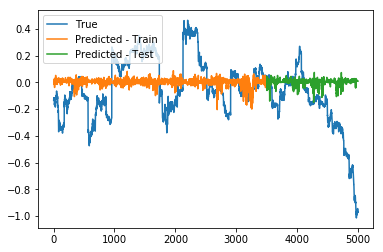

2019-03-15 17:56:28,667 - VOC_TOPICS - INFO - Epoch 10, loss: 0.004.


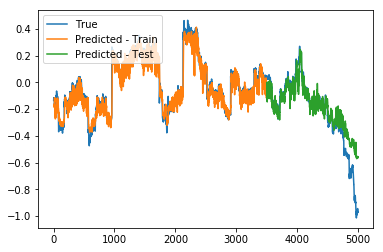

2019-03-15 17:58:29,616 - VOC_TOPICS - INFO - Epoch 20, loss: 0.002.


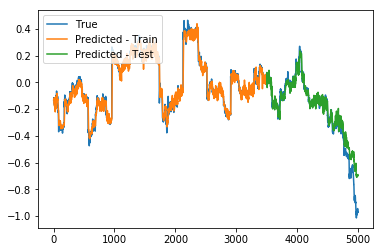

2019-03-15 18:00:33,929 - VOC_TOPICS - INFO - Epoch 30, loss: 0.001.


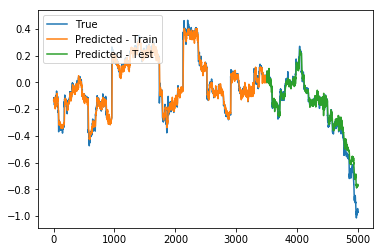

2019-03-15 18:02:42,617 - VOC_TOPICS - INFO - Epoch 40, loss: 0.001.


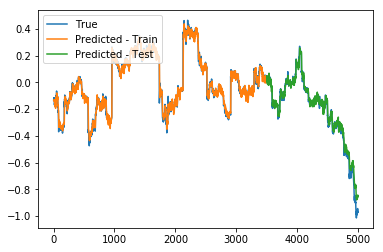

2019-03-15 18:04:40,989 - VOC_TOPICS - INFO - Epoch 50, loss: 0.001.


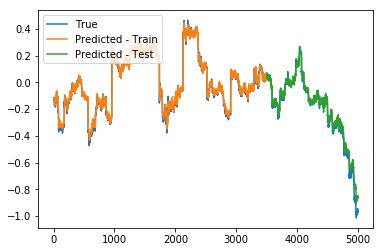

2019-03-15 18:06:52,782 - VOC_TOPICS - INFO - Epoch 60, loss: 0.001.


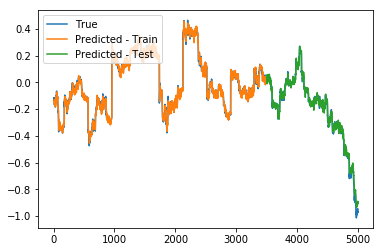

2019-03-15 18:09:00,615 - VOC_TOPICS - INFO - Epoch 70, loss: 0.001.


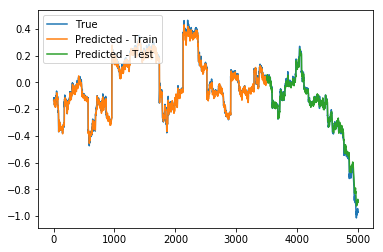

2019-03-15 18:11:05,637 - VOC_TOPICS - INFO - Epoch 80, loss: 0.001.


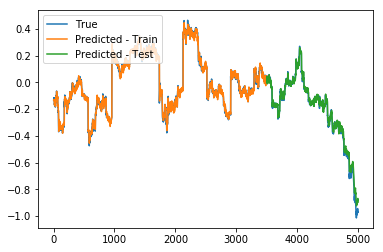

2019-03-15 18:13:05,423 - VOC_TOPICS - INFO - Epoch 90, loss: 0.001.


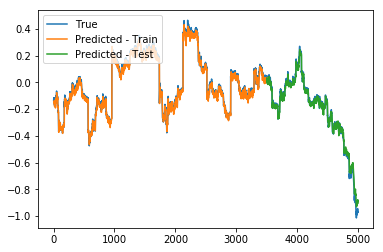

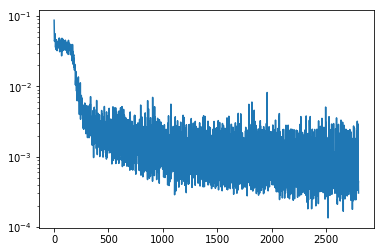

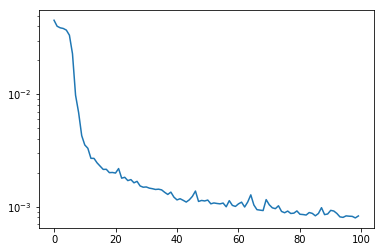

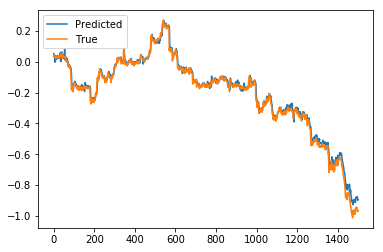

mean predicted price from pred_df: -0.194818, mean predicted price from model.predict: -0.193329
The main method returns a dictionary with keys ['model', 'dataframe', 'y_pred', 'test_size']
1500 1500


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


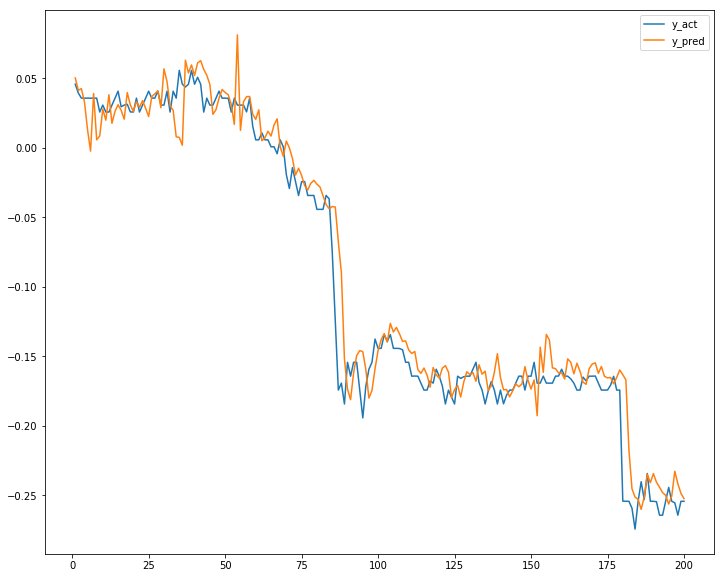

In [8]:
if __name__=='__main__':
    save_model = True
#     fname_no_ext = 'sin_vals'
    fname_no_ext = 'uso_full'
#     fname_no_ext = 'nasdaq100_padding'
    rows_to_use = 5000
    return_dict = main(FILE_NAME_NO_EXTENSION=fname_no_ext,subset_rows=rows_to_use)
    print(f'The main method returns a dictionary with keys {list(return_dict.keys())}')
    # get the model
    m = return_dict['model']
    
    # 
    if save_model:
        # 5.01 pickle the instantiated da_rnn instance
        pickle.dump(m,open(f'{fname_no_ext}.pt','wb'))

        # 5.02 load the pickled da_rnn instance
        m = pickle.load(open(f'{fname_no_ext}.pt','rb'))

    '''
    graph a portion of the actuals vs the predictions by changing the variables:
        1. num_to_view
        2. beg_index
    ''' 
    num_to_view = 200
    beg_index = 1
    end_index = beg_index+num_to_view
    
    y_pred = m.predict(on_train = False)
    test_size = y_pred.shape[0]
    y_act = m.y[-1*test_size:]
    print(len(y_act),len(y_pred))
    df_review = pd.DataFrame({'y_act':y_act,'y_pred':y_pred})

    df_review.iloc[beg_index:end_index].plot(y=['y_act','y_pred'],figsize=(12,10))

## 5.0 Save this ipynb notebook as a python module
#### run the command below in a command line in order to save this workbook as a python module

In [9]:
#jupyter nbconvert da_rnn_from_csv.ipynb --to python

### End

In [10]:
dfuso = pd.read_csv('./data/uso_full.csv')

In [12]:
dfuso.tail()

,year,month,day,hour,minute,open,high,low,close,volume,NDX
1030366,2018,12,18,11,54,10.0400,10.04,10.02,10.0300,90734,10.0200
1030367,2018,12,18,11,55,10.0300,10.04,10.02,10.0200,140961,10.0290
1030368,2018,12,18,11,56,10.0300,10.03,10.02,10.0290,28898,10.0233
1030369,2018,12,18,11,57,10.0200,10.03,10.01,10.0233,112914,10.0268
1030370,2018,12,18,11,58,10.0285,10.03,10.02,10.0268,20700,10.0300
